In [89]:
import pandas as pd
import geopandas as gp
import warnings
warnings.filterwarnings('ignore')
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import jieba
from jieba import analyse
import jieba.posseg as pseg

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 或者SimHei

In [212]:
calendar = pd.read_pickle('1/calendar.pkl')
lists = pd.read_pickle('1/lists.pkl')
reviews = pd.read_pickle('1/reviews.pkl')
neigh = pd.read_pickle('1/neigh.pkl')

In [213]:
a = calendar.describe().T
a['min-1.5-IQR'] = a['25%'] - 1.5*(a['75%']-a['25%'])
a['max-1.5-IQR'] = a['75%'] + 1.5*(a['75%']-a['25%'])
a['min-3-IQR'] = a['25%'] - 3*(a['75%']-a['25%'])
a['max-3-IQR'] = a['75%'] + 3*(a['75%']-a['25%'])
a
# 明显看出来，price有很大问题  这里先不做处理，后面结合地段进行分析

,count,mean,std,min,25%,50%,75%,max,min-1.5-IQR,max-1.5-IQR,min-3-IQR,max-3-IQR
listing_id,10384980.0,2.628583e+07,6.403200e+06,44054.0,22456156.0,27877650.0,31344816.25,3.395441e+07,9123165.625,4.467781e+07,-4209824.75,58010797.0
price,10384980.0,6.643488e+02,1.967888e+03,1.0,255.0,399.0,608.00,9.000000e+04,-274.500,1.137500e+03,-804.00,1667.0
adjusted_price,10384980.0,6.637883e+02,1.967274e+03,1.0,255.0,399.0,608.00,9.000000e+04,-274.500,1.137500e+03,-804.00,1667.0
minimum_nights,10384622.0,2.728788e+00,1.754409e+01,1.0,1.0,1.0,1.00,1.125000e+03,1.000,1.000000e+00,1.00,1.0
maximum_nights,10384622.0,3.611298e+04,5.928479e+06,1.0,1125.0,1125.0,1125.00,1.000000e+09,1125.000,1.125000e+03,1125.00,1125.0


In [214]:
calendar['minimum_nights'].fillna(calendar['minimum_nights'].mean(),inplace=True)
calendar['maximum_nights'].fillna(calendar['maximum_nights'].mean(),inplace=True)
# 用平均值来填充可住房天数缺失
# 缺失率
calendar.isnull().sum()/calendar.shape[0]

listing_id        0.0
date              0.0
available         0.0
price             0.0
adjusted_price    0.0
minimum_nights    0.0
maximum_nights    0.0
dtype: float64

In [215]:
lists.isnull().sum()/lists.shape[0]

id                                0.000000
name                              0.000035
host_id                           0.000000
host_name                         0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.392169
reviews_per_month                 0.392169
calculated_host_listings_count    0.000000
availability_365                  0.000000
summary                           0.106144
space                             0.337340
description                       0.086918
neighborhood_overview             0.367988
notes                             0.536834
transit                           0.372382
access                            0.472339
interaction                       0.452481
house_rules

In [216]:
lists['name'].fillna('无',inplace=True)
# last_review, reviews_per_month,square_feet 缺失超过25%且难以填充，抛弃
lists.drop(columns=['last_review','reviews_per_month','square_feet'],inplace=True)
# summary,space,description,neighborhood_overvie,notes,等 ,用‘无填充’
fill_set = ['summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'host_about', 'host_response_time',]
for x in fill_set:
    lists[x].fillna('无',inplace=True)

for x in ['bathrooms','bedrooms','beds']:
    lists[x].fillna(lists[x].mode(),inplace=True)
lists.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,bedrooms,beds,is_business_travel_ready,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,朝阳区 / Chaoyang,39.89503,116.45163,Entire home/apt,792,1,...,3.0,4.0,f,91.0,9.0,9.0,10.0,10.0,10.0,9.0
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,密云县 / Miyun,40.68434,117.17231,Private room,1201,1,...,1.0,1.0,f,100.0,10.0,9.0,10.0,10.0,9.0,9.0
2,128496,Heart of Beijing: House with View 2,467520,Cindy,东城区,39.93213,116.42200,Entire home/apt,389,3,...,2.0,3.0,f,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,161902,cozy studio in center of Beijing,707535,Robert,东城区,39.93357,116.43577,Entire home/apt,376,1,...,1.0,1.0,f,77.0,8.0,7.0,9.0,9.0,9.0,8.0
4,162144,"nice studio near subway, sleep 4",707535,Robert,朝阳区 / Chaoyang,39.93668,116.43798,Entire home/apt,537,1,...,1.0,2.0,f,87.0,8.0,7.0,9.0,9.0,9.0,9.0


In [217]:
# 查看review评分 的缺失值.  用review打算建模补充,毕竟评分挺重要的
lists.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,bedrooms,beds,is_business_travel_ready,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,朝阳区 / Chaoyang,39.89503,116.45163,Entire home/apt,792,1,...,3.0,4.0,f,91.0,9.0,9.0,10.0,10.0,10.0,9.0
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,密云县 / Miyun,40.68434,117.17231,Private room,1201,1,...,1.0,1.0,f,100.0,10.0,9.0,10.0,10.0,9.0,9.0
2,128496,Heart of Beijing: House with View 2,467520,Cindy,东城区,39.93213,116.42200,Entire home/apt,389,3,...,2.0,3.0,f,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,161902,cozy studio in center of Beijing,707535,Robert,东城区,39.93357,116.43577,Entire home/apt,376,1,...,1.0,1.0,f,77.0,8.0,7.0,9.0,9.0,9.0,8.0
4,162144,"nice studio near subway, sleep 4",707535,Robert,朝阳区 / Chaoyang,39.93668,116.43798,Entire home/apt,537,1,...,1.0,2.0,f,87.0,8.0,7.0,9.0,9.0,9.0,9.0


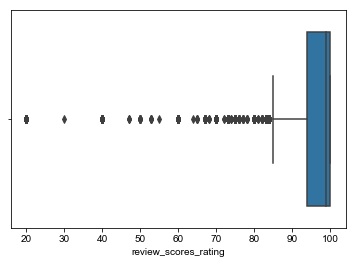

In [218]:

sns.boxplot(lists['review_scores_rating'])

In [219]:
lists[lists['review_scores_rating'] < 30].head()
reviews[reviews['listing_id']==  15979144]
# 结合review来看，评分低也是有可能的

,listing_id,date,id,reviewer_id,reviewer_name,comments
50472,15979144,2016-12-21,122086987,75571287,奕含,The host canceled this reservation 4 days befo...
50473,15979144,2017-02-16,132263142,81638183,文,"该房屋位于地下负一层,是由一个地下储藏室改造而成的,房屋的网络一直无法使用,且进入房屋后手机..."


In [220]:
lists.rename(columns={'id':'listing_id'},inplace=True)

In [221]:
list_review = pd.merge(lists,reviews,on='listing_id',how='left')
list_review.drop(columns=['date','id','reviewer_id','reviewer_name'],inplace=True)

In [222]:
# 可以发现 comment为空的数量基本和评分数量一致，无法建模预测评分
list_review.isnull().sum()

listing_id                            0
name                                  0
host_id                               0
host_name                             0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
calculated_host_listings_count        0
availability_365                      0
summary                               0
space                                 0
description                           0
neighborhood_overview                 0
notes                                 0
transit                               0
access                                0
interaction                           0
house_rules                           0
host_since                            0
host_about                            0
host_response_time                    0


In [223]:
text = 'Modern and Comfortable Living in CBD'
keys = analyse.textrank(text,allowPOS=('an','n','ns','vn','eng'),topK=5)

keys


['Living', 'Comfortable', 'Modern', 'CBD']

In [230]:

reviews['reviewer_name'].fillna('无',inplace=True)
reviews['comments'].fillna('无',inplace=True)
reviews.isnull().sum()

listing_id       0
date             0
id               0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [232]:
calendar.to_pickle('2/calendar.pkl')
lists.to_pickle('2/lists.pkl')
reviews.to_pickle('2/reviews.pkl')
neigh.to_pickle('2/neigh.pkl')

In [233]:
del reviews,calendar,lists,neigh,list_review
gc.collect()

958